# XGBoost y Decision Tree 
Se buscará hacer árboles de decisión para la busqueda de multiples labels.

Importar librerías y modelos 

In [480]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

#### Importar base de datos 
Se va a utilizar una base de datos sobre géneros de música:<br>
https://www.kaggle.com/datasets/mrmorj/dataset-of-songs-in-spotify/data

In [456]:
#importar dataset csv
genre_data = pd.read_csv('genres_v2.csv')


C:\Users\A01280544\AppData\Local\Temp\ipykernel_22556\2439067423.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  genre_data = pd.read_csv('genres_v2.csv')


Visualizamos la base de datos que vamos a utilizar:

In [471]:
genre_data.head()

danceability  energy  loudness  speechiness  acousticness  \
0         0.831   0.814    -7.364       0.4200        0.0598   
1         0.719   0.493    -7.230       0.0794        0.4010   
2         0.850   0.893    -4.783       0.0623        0.0138   
3         0.476   0.781    -4.710       0.1030        0.0237   
4         0.798   0.624    -7.668       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.013400    0.0556   0.3890  156.985       124539               4   
1          0.000000    0.1180   0.1240  115.080       224427               4   
2          0.000004    0.3720   0.0391  218.050        98821               4   
3          0.000000    0.1140   0.1750  186.948       123661               3   
4          0.000000    0.1660   0.5910  147.988       123298               4   

   genre  
0      0  
1      0  
2      0  
3      0  
4      0

Cambiamos el valor que contiene el género nuestro dataset:

In [458]:
genre_data['genre'] = genre_data['genre'].astype(str)

Cambiamos la columna de género a la nueva:

In [459]:
genre_data.to_csv('genres_v2.csv', index=False)

Droppeamos valores que nos son necesarios para el modelo de regresión multiclase. <br>
<br>
En este caso serian los que son strings y además tienen datos nulos no importantes como:<br>
analysis_url, uri, mode, analysis_url, Unnamed: 0, id, song_name, track_href, title, key, type

In [461]:

genre_data = genre_data.drop(columns=['analysis_url','uri','mode','analysis_url','Unnamed: 0', 'id','song_name','track_href','title','key','type' ])


Visualizamos los datos que quedaron:

In [472]:
genre_data.head()

danceability  energy  loudness  speechiness  acousticness  \
0         0.831   0.814    -7.364       0.4200        0.0598   
1         0.719   0.493    -7.230       0.0794        0.4010   
2         0.850   0.893    -4.783       0.0623        0.0138   
3         0.476   0.781    -4.710       0.1030        0.0237   
4         0.798   0.624    -7.668       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.013400    0.0556   0.3890  156.985       124539               4   
1          0.000000    0.1180   0.1240  115.080       224427               4   
2          0.000004    0.3720   0.0391  218.050        98821               4   
3          0.000000    0.1140   0.1750  186.948       123661               3   
4          0.000000    0.1660   0.5910  147.988       123298               4   

   genre  
0      0  
1      0  
2      0  
3      0  
4      0

Utizamos una función de label encoder para convertir los géneros de musica que utilizaremos para nuestra classificación multiclase de Xgboost y Decision Tree

In [473]:
# Utilizamos un label_encoder para identificar los datos que utilizaremos como label
label_encoder = preprocessing.LabelEncoder()

genre_data['genre']= label_encoder.fit_transform(genre_data['genre'])
  
genre_data['genre'].unique()

#Visualizamos los datos nuevamente 
genre_data.head()

danceability  energy  loudness  speechiness  acousticness  \
0         0.831   0.814    -7.364       0.4200        0.0598   
1         0.719   0.493    -7.230       0.0794        0.4010   
2         0.850   0.893    -4.783       0.0623        0.0138   
3         0.476   0.781    -4.710       0.1030        0.0237   
4         0.798   0.624    -7.668       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.013400    0.0556   0.3890  156.985       124539               4   
1          0.000000    0.1180   0.1240  115.080       224427               4   
2          0.000004    0.3720   0.0391  218.050        98821               4   
3          0.000000    0.1140   0.1750  186.948       123661               3   
4          0.000000    0.1660   0.5910  147.988       123298               4   

   genre  
0      0  
1      0  
2      0  
3      0  
4      0

Dividimos nuestras Features X de nuestras Label y

In [395]:
X = genre_data.drop(columns=["genre"])
y = genre_data['genre']

Estandarizamos los valores para evitar que las futuras predicciones tengan mucho ruido

In [464]:
dataScaler = StandardScaler()
scaler = dataScaler.fit(X)
X_scaled = scaler.transform(X)
#Visualizamos los valores
print(X_scaled)

[[ 1.22360786e+00  2.80079101e-01 -3.05514474e-01  2.24655159e+00
  -2.12852723e-01 -7.27230861e-01 -9.02637010e-01  1.36789823e-01
   3.98876358e-01 -1.22699247e+00  1.02184127e-01]
 [ 5.08479648e-01 -1.46618532e+00 -2.59953760e-01 -4.53056623e-01
   1.78451799e+00 -7.63370236e-01 -5.47230508e-01 -9.99586073e-01
  -1.35856366e+00 -2.56796293e-01  1.02184127e-01]
 [ 1.34492425e+00  7.09845111e-01  5.72039279e-01 -5.88591856e-01
  -4.82134824e-01 -7.63359070e-01  8.99456216e-01 -1.36365518e+00
   2.95986132e+00 -1.47678730e+00  1.02184127e-01]
 [-1.04309316e+00  1.00556590e-01  5.96859668e-01 -2.66002149e-01
  -4.24180633e-01 -7.63370236e-01 -5.70012976e-01 -7.80887316e-01
   1.65548477e+00 -1.23552035e+00 -3.62445337e+00]
 [ 1.01290044e+00 -7.53535355e-01 -4.08876094e-01  1.23994489e+00
   7.07389586e-01 -7.63370236e-01 -2.73840891e-01  1.00300843e+00
   2.15541325e-02 -1.23904611e+00  1.02184127e-01]
 [ 5.21249794e-01 -1.05817962e+00 -1.64207542e+00  2.19899537e+00
  -2.98320521e-01 -

Hacemos el split de los datos para crear Train y Test set

In [449]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## XgBoost

In [465]:
# Inicializamos nuestro modelo de Xgboost y agregamos los parámetros que utilizará para entrenar
xgboost = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=12, 
    learning_rate=0.1, 
    objective='multi:softprob')
# Entrenamos con los datos del Train set
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Generamos predicciones con el test set 

In [466]:
y_pred = xgboost.predict(X_test)
#Mostrar las primeras 100 predicciónes
print(y_pred[:100])

[ 5  0  1 11  3 12 12  5  7  7  4 12  6  2 12 13  4 10 14  7  7  0  8  0
 12  2  1  0  0  9  8  3  7  8  7 13  6  8  4  7  0  2 12  0 14  6  6 11
  7 11  2  8  1  5  0  7  9  9  5 10  0 11  7  0 14  5  9  8  7  7 13 14
  2 13  1 12  9  5  8 11 13  9  6 14 11  9  9  7  7  6  7  0 11  7  0  9
  7  0 10  2]


In [469]:
# Muetra los valores clasificados incorrectamente y un informe detallado de las métricas de clasificación, como precisión, recall y F1-score
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print(metrics.classification_report(y_test, y_pred))

# Precisión del modelo XGBoost comparando las predicciones con los valores reales
y_pred_tree2 = xgboost.predict(X_test)
print('XGBoost Classifier Score: {}'.format(accuracy_score(y_test, y_pred_tree2)))

Misclassified samples: 2768
              precision    recall  f1-score   support

           0       0.54      0.47      0.50       970
           1       0.73      0.74      0.73       341
           2       0.43      0.40      0.41       621
           3       0.24      0.11      0.15        98
           4       0.45      0.32      0.37       341
           5       0.40      0.35      0.37       396
           6       0.34      0.30      0.32       384
           7       0.39      0.50      0.44      1192
           8       0.96      0.98      0.97       599
           9       0.91      0.94      0.93       619
          10       0.95      0.93      0.94       598
          11       0.89      0.91      0.90       568
          12       0.88      0.87      0.88       590
          13       0.84      0.89      0.86       562
          14       0.87      0.87      0.87       582

    accuracy                           0.67      8461
   macro avg       0.65      0.64      0.64      846

Cross Validation

In [470]:
# Define la validación cruzada K-Fold con 10 particiones y mezcla aleatoria de los datos
kfold = KFold(n_splits=10, shuffle=True)

# Calcula las puntuaciones de validación cruzada usando el modelo XGBoost, los datos de entrada X e y, y el KFold definido
score = cross_val_score(xgboost, X, y, cv=kfold)

print("Cross-Validation Scores:", score, "\n")

# Calcula la media de las puntuaciones obtenidas en la validación cruzada
mean_score = np.mean(score)

# Calcula la desviación estándar de las puntuaciones obtenidas en la validación cruzada
std_dev_score = np.std(score)

#Visualiza los valores de media y puntuación estándar
print("Mean Score:", mean_score)
print("Standard Deviation Score:", std_dev_score)

Cross-Validation Scores: [0.67501773 0.66154573 0.67099976 0.66320019 0.66769085 0.66099291
 0.65886525 0.66879433 0.65271868 0.67281324] 

Mean Score: 0.6652638663294058
Standard Deviation Score: 0.00661841529228662


In [483]:
y_train_pred = xgboost.predict(X_train)
train_error = mean_squared_error(y_train, y_train_pred, squared=False)  # RMSE de entrenamiento

# Calcular el error de validación
y_test_pred = xgboost.predict(X_test)
test_error = mean_squared_error(y_test, y_test_pred, squared=False)  # RMSE de validación

print(f'Bias: {train_error}')
print(f'Variance: {test_error}')

c:\Users\A01280544\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Bias: 1.1286865557862478
Variance: 3.070903055097839


c:\Users\A01280544\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


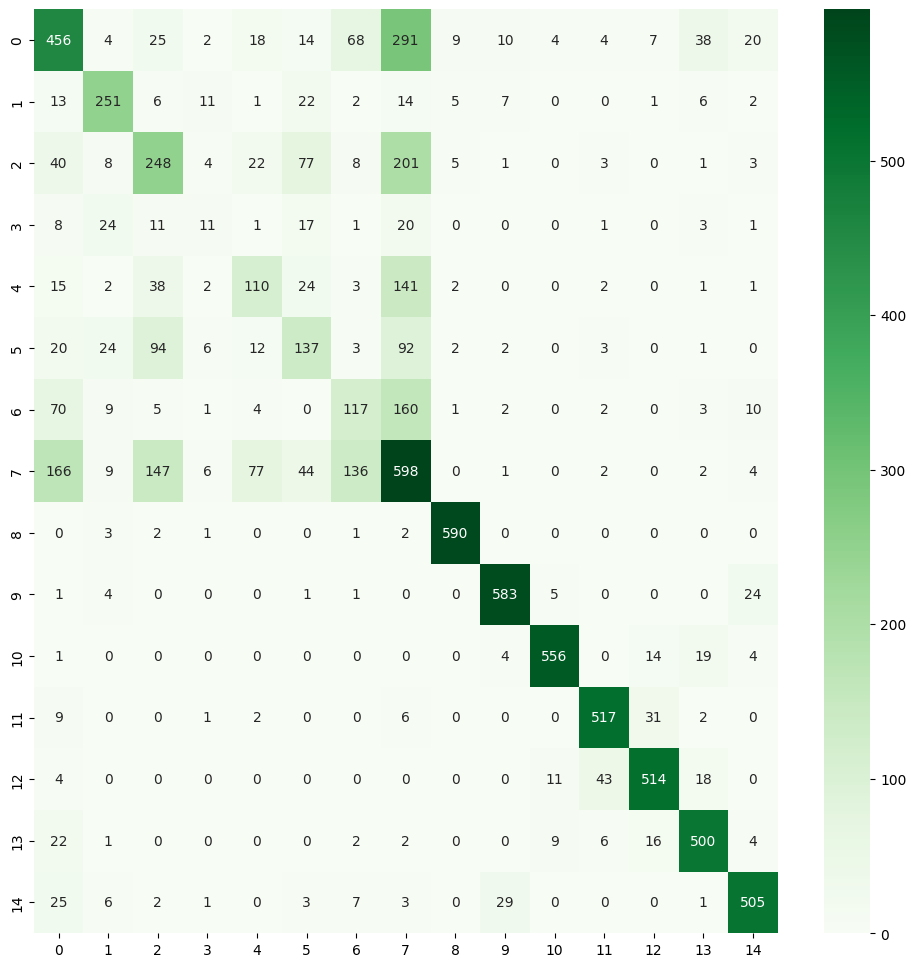

In [445]:
#Gráfica una una matriz de confusión para mostrar las predicciones del modelo (y_pred) con los valores reales (y_test)
xgb_cm = confusion_matrix(y_test, y_pred)
fig = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Greens")

Grid Search

In [439]:
#Función de Grid Search para encontrar los mejores parámetros del modelo de XGboost
from sklearn.model_selection import GridSearchCV
#Establece los parámetros
parameters = {'n_estimators':(5, 50, 200),'max_depth':[2, 3, 10]}
gs_rf_clf = GridSearchCV(xgboost, parameters)
#Entrena con los valores a utilizar
gs_rf_clf.fit(X_train, y_train)
y_pred_gs_rf = xgboost.predict(X_test)
print('GS_XgBoost Classifier Score: {}'.format(accuracy_score(y_test, y_pred_gs_rf)))

GS_XgBoost Classifier Score: 0.6728519087578301


## Decision Tree

In [476]:
# Inicializamos nuestro modelo de Xgboost y agregamos los parámetros que utilizará para entrenar
dtree_model = DecisionTreeClassifier(max_depth = 14, random_state=42)
dtree_model.fit(X_train, y_train) 
y_pred2 = dtree_model.predict(X_test) 

#Mostrar las primeras predicciónes
print(y_pred2[:100])

# Creating a confusion matrix que nos servirá parala gráfica de confusión que nos muestre los valores posteriormente
cm = confusion_matrix(y_test, y_pred2)

[ 2  7  1 11  5 12 12  5  7  5  7 11  0  5 12 13  4  0 14  7  7  0  1 13
 12 14  1  7  0 14  8  2  7  8  0 13  0  8  4  2  0  2 12  0 14  7  7 11
  7 11  2  8  1  5  0  7  9  9  7  0  0 11  7  0 14  5  9  8  7  6 13 14
  7 13  1 12  9  7  8 11 10  9  6 14 11  9  9  7  7  0  7  7 11  7  4  9
  7 13  9  2]


In [475]:
# Muetra los valores clasificados incorrectamente y un informe detallado de las métricas de clasificación, como precisión, recall y F1-score
print('Misclassified samples: %d' % (y_test != y_pred2).sum())
print(metrics.classification_report(y_test, y_pred2))
# Precisión del modelo Decision Tree comparando las predicciones con los valores reales
y_pred_tree = dtree_model.predict(X_test)
print('Tree Classifier Score: {}'.format(accuracy_score(y_test, y_pred_tree)))

Misclassified samples: 3167
              precision    recall  f1-score   support

           0       0.46      0.40      0.43       970
           1       0.58      0.56      0.57       341
           2       0.39      0.39      0.39       621
           3       0.10      0.08      0.09        98
           4       0.58      0.30      0.39       341
           5       0.34      0.28      0.30       396
           6       0.33      0.22      0.26       384
           7       0.41      0.60      0.48      1192
           8       0.96      0.94      0.95       599
           9       0.84      0.87      0.85       619
          10       0.92      0.87      0.90       598
          11       0.84      0.84      0.84       568
          12       0.81      0.80      0.81       590
          13       0.77      0.80      0.79       562
          14       0.80      0.76      0.78       582

    accuracy                           0.63      8461
   macro avg       0.61      0.58      0.59      846

Cross Validation

In [477]:
# Define la validación cruzada K-Fold con 10 particiones y mezcla aleatoria de los datos
kfold = KFold(n_splits=10, shuffle=True)

# Calcula las puntuaciones de validación cruzada usando el modelo Decision Tree, los datos de entrada X e y, y el KFold definido
score = cross_val_score(dtree_model, X, y, cv=kfold)

print("Cross-Validation Scores:", score, "\n")

# Calcula la media de las puntuaciones obtenidas en la validación cruzada
mean_score = np.mean(score)

# Calcula la desviación estándar de las puntuaciones obtenidas en la validación cruzada
std_dev_score = np.std(score)

#Visualiza los valores de media y puntuación estándar
print("Mean Score:", mean_score)
print("Standard Deviation Score:", std_dev_score)

Cross-Validation Scores: [0.63932876 0.62372961 0.62798393 0.63034744 0.63223824 0.62174941
 0.63120567 0.62624113 0.6144208  0.62269504] 

Mean Score: 0.6269940040665738
Standard Deviation Score: 0.006518491119475002


In [484]:
y_train_pred = dtree_model.predict(X_train)
train_error = mean_squared_error(y_train, y_train_pred, squared=False)  # RMSE de entrenamiento

# Calcular el error de validación
y_test_pred = dtree_model.predict(X_test)
test_error = mean_squared_error(y_test, y_test_pred, squared=False)  # RMSE de validación

print(f'Bias: {train_error}')
print(f'Variance: {test_error}')

Bias: 2.4622489510963903
Variance: 3.5115424175282945


c:\Users\A01280544\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\A01280544\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


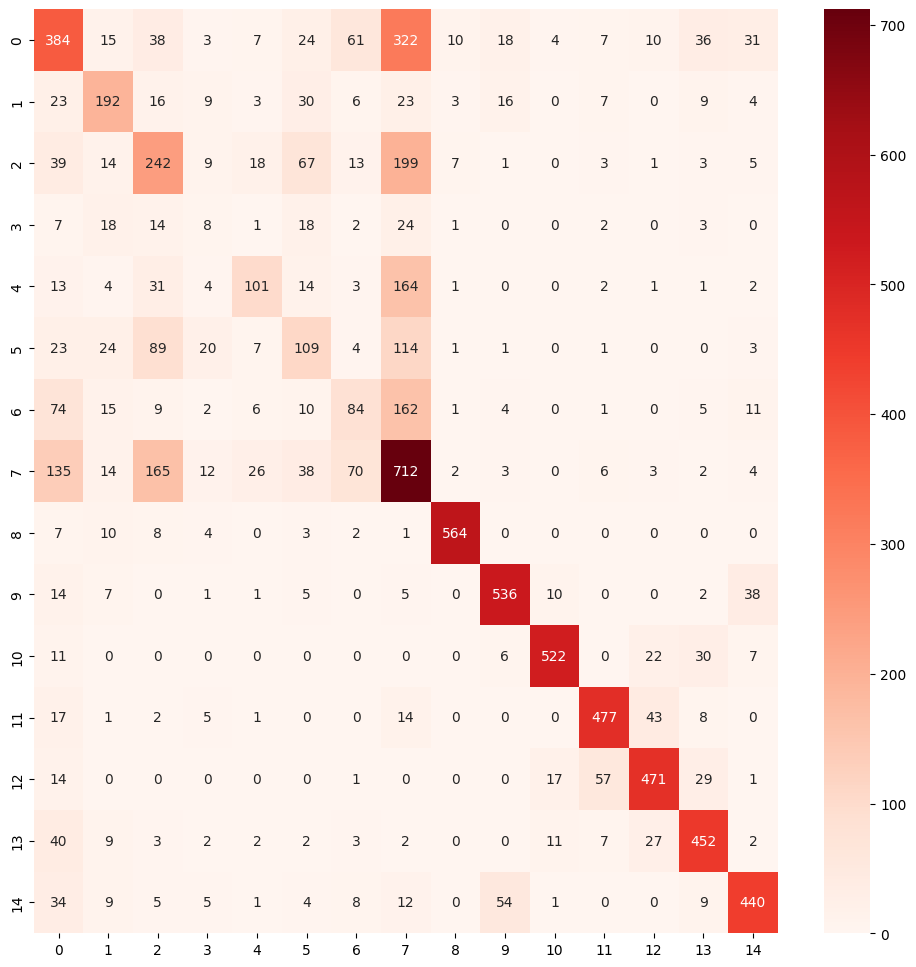

In [478]:
#Gráfica una una matriz de confusión para mostrar las predicciones del modelo (y_pred) con los valores reales (y_test)
fig = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")

Grid Search

In [479]:
#Función de Grid Search para encontrar los mejores parámetros del modelo de XGboost
from sklearn.model_selection import GridSearchCV
#Establece los parámetros
parameters = {'max_depth':[2, 3, 10, 15]}
gs_rf_clf = GridSearchCV(dtree_model, parameters)
#Entrena con los valores a utilizar
gs_rf_clf.fit(X_train, y_train)
y_pred_gs_rf = dtree_model.predict(X_test)
print('')
print('GS_RF Classifier Score: {}'.format(accuracy_score(y_test, y_pred_gs_rf)))




GS_RF Classifier Score: 0.6256943623685144
